# **Práctica 3: Brillo y contraste**

<img src ="https://epigijon.uniovi.es/image/image_gallery?uuid=903ae5c8-b29b-430e-980d-1a19a885c736&groupId=3743853&t=1688576582973" width=300 px>

Este cuaderno desarrolla contenidos prácticos de la asignatura **Visión artificial** del Grado en Ciencia e Ingeniería de Datos.

***

# Histograma

Para analizar el brillo y el contraste de una imagen es importante entender el histograma de intensidades. Para ello se va a comenzar la práctica realizando una función para visualizar una imagen junto a su histograma.


> Implementa una función que dada una imagen realice una visualización conjunta tanto de la imagen como de su histograma y distribución acumulada siguiendo las indicaciones que se muestran a continuación:
>
> Se debe verificar que la imagen es de tipo uint8. El histograma tendrá 256 bins, desde 0 a 255
>
> La función debe permitir el uso de imágenes en color o de imágenes en escala de grises
>
> Para calcular el histograma se debe implementar una función propia
>

A continuación se muestra algo de ayuda.



In [24]:
# Importar bibliotecas que pueden ser necesarias
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import skimage 

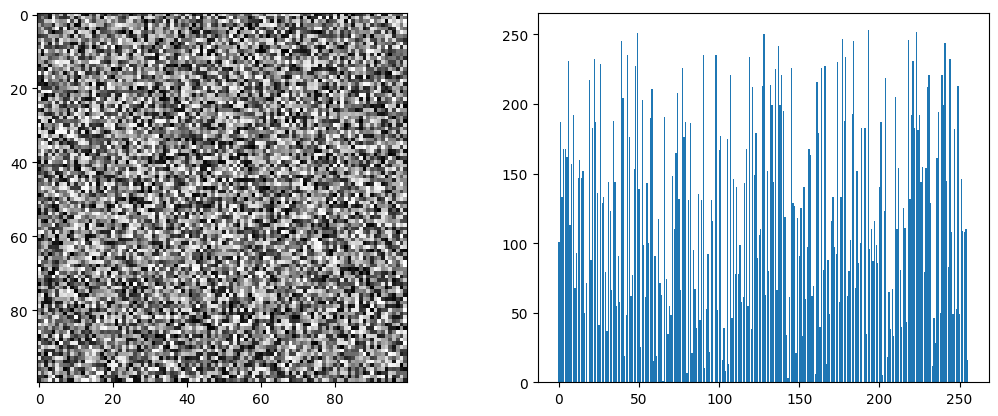

In [25]:
# Creación de la figura
width, height = plt.rcParams['figure.figsize']
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(2*width, height))

# La primera se usará para la imagen, la segunda para el histograma

# Ejemplo de visualización de la imagen
img = np.random.randint(0, 256, size=(100, 100), dtype=np.uint8)
ax_img.imshow(img, cmap='gray')

# Ejemplo de visualización del histograma
hist = np.random.randint(0, 256, size=(256,), dtype=np.uint8)
ax_hist.bar(np.arange(256), hist)
plt.show()

In [26]:
def histogram(img):
    a=np.zeros(256)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            a[img[i,j]] +=1
    return a


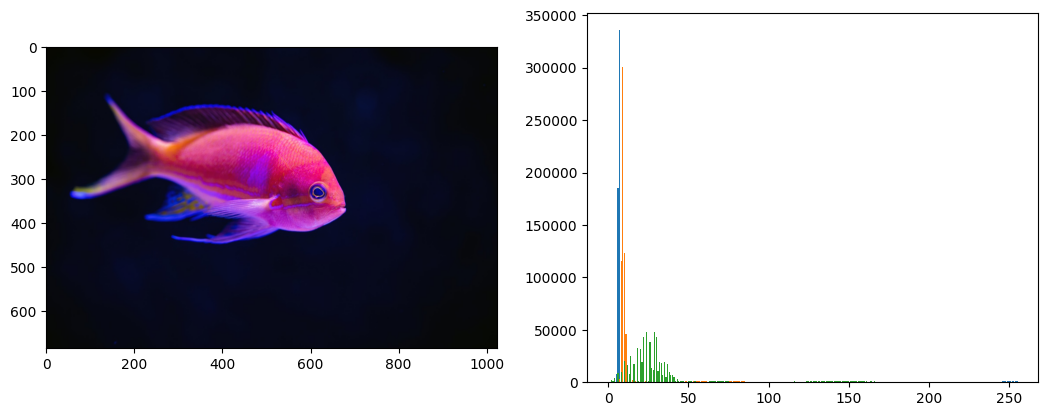

In [27]:
def iter_channels(color_image):
    for channel in np.rollaxis(color_image, -1):
        yield channel

# Función para visualizar el histograma de una imagen
# Esta función está sin terminar
def plot_histogram(img):
    width, height = plt.rcParams['figure.figsize']
    fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(2*width, height))
    if img.dtype!=np.uint8:
        print("La imagen no es de tipo uint8")
        return
    ax_img.imshow(img)
    if img.ndim == 2:
        # imagen en escala de grises
        hist=histogram(img)
        ax_hist.bar(np.arange(256), hist)
        plt.show()
    elif img.ndim == 3:
        # imagen en color
        # `channel` es el canal rojo, verde o azul de la imagen.
        for channel, channel_color in zip(iter_channels(img), 'rgb'):
            # crear histograma de cada canal
            hist=histogram(channel)
            ax_hist.bar(np.arange(256), hist)
            
    plt.show()

img = skimage.io.imread('pez.jpg')
plot_histogram(img)


## Ajuste de contraste lineal

Una vez que se tiene la visualización del histograma se puede analizar mejor el brillo y el contraste. También es más fácil entender cómo funcionan los métodos de ajuste de contraste.

> Crea una función que realice un ajuste de intensidad afín usando la ecuación $s = ra+b$, donde $s$ es el valor del píxel de salida, $r$ el de entrada y $a$ y $b$ son dos constantes. La función debe evitar que el resultado se salga del rango de representación (`np.clip`). Para ello se recomienda realizar una conversión a flotante para realizar las operaciones (`img.astype(np.double)`). Después de la operación se debe volver a convertir a su formato original.

> Prueba con diversos valores de $a$ y $b$ y analiza el resultado.


In [28]:
def intensidad(r,a,b):
    print(r.dtype)
    r_flotante = r.astype(np.double)
    s = np.clip(a * r_flotante + b, 0, 255)
    s = s.astype(r.dtype)
    return s

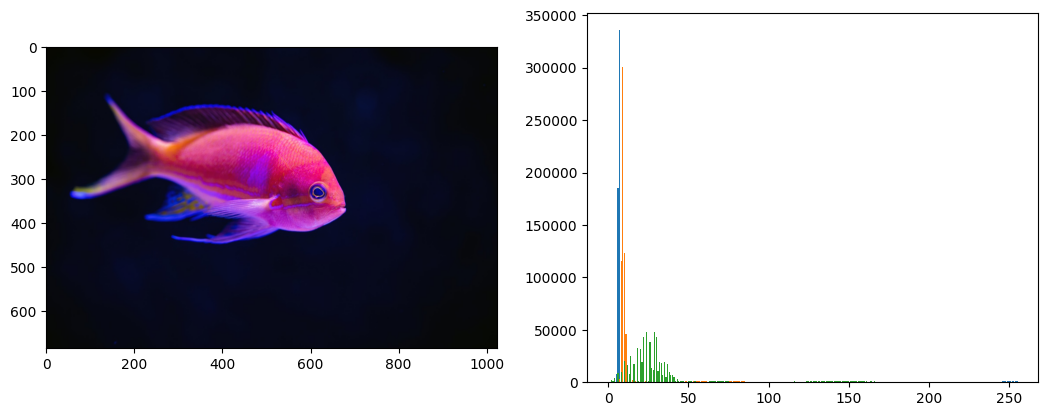

In [29]:
img = skimage.io.imread('pez.jpg')
plot_histogram(img)

uint8


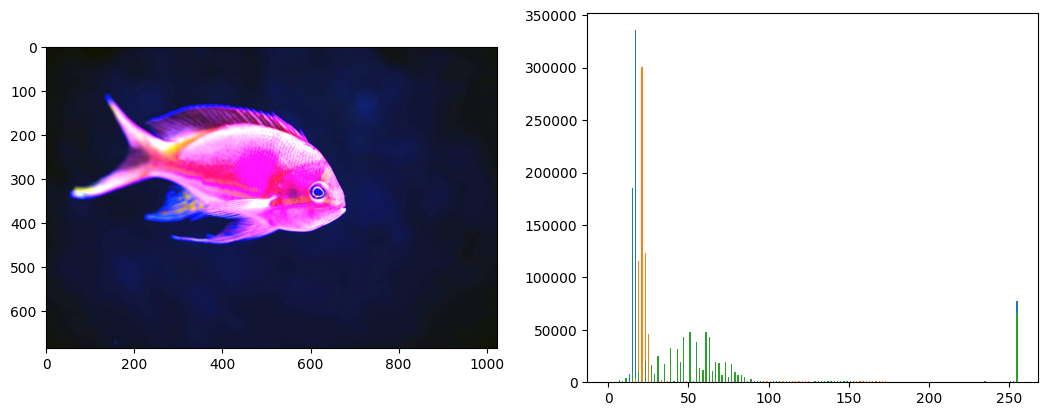

In [30]:
a=2
b=3
intens=intensidad(img,a,b)
plot_histogram(intens)

> Realiza la normalización de la imagen usando $r_{norm} =  \frac{r - r_{min}} {r_{max} - r_{min}}$, donde $r_{min}$ es el valor de intensidad mínimo de la imagen, y  $r_{max}$ es el máximo. Este tipo de normalización (min-max normalization) debe retornar una imagen en el rango [0, 1]. En el caso de imagen de color, realiza este proceso para cada canal.

> Convierte la imagen normalizada al rango [0, 255] (se consigue simplemente multiplicando por 255).

> Repite el proceso usando el percentil 2 y 98 como valores de $r_{min}$ y $r_{max}$.

> Usa las técnicas anteriores para visualizar la imagen `http://www.atc.uniovi.es/grado/3va/prac/convection.png`




In [44]:
def normalizacion(img):
    if img.ndim == 2:
        r_min = np.min(image)
        r_max = np.max(image)
        # Aplicar la fórmula de min-max normalization
        image=np.clip((img - r_min) / (r_max - r_min), 0, 1)
    elif img.ndim == 3:
        for channel, channel_color in zip(iter_channels(img), 'rgb'):
            channel_min = np.min(channel)
            channel_max = np.max(channel)
            r_norm=np.clip((channel - channel_min) / (channel_max - channel_min), 0, 1)
            r_norm = r_norm.astype(img.dtype)
    return img

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 27664  100 27664    0     0   300k      0 --:--:-- --:--:-- --:--:--  310k


uint8


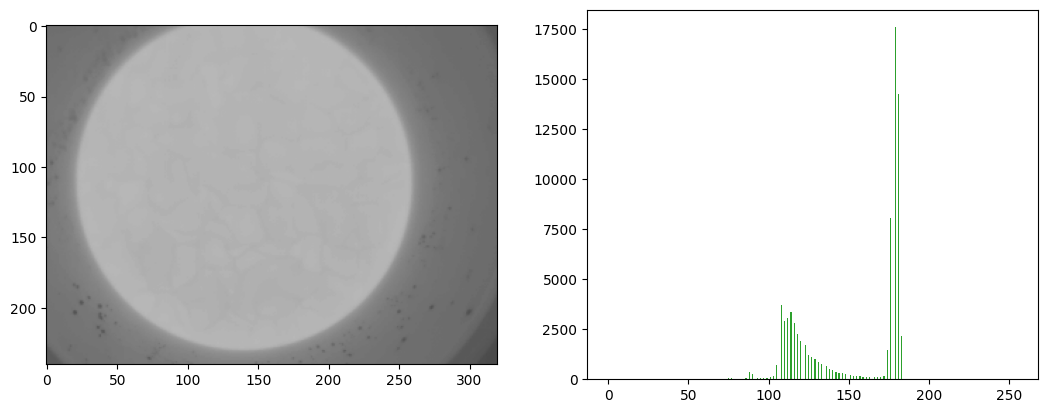

In [45]:
!curl www.atc.uniovi.es/grado/3va/prac/convection.png --output convection.jpg
img = skimage.io.imread('convection.jpg')
img2=normalizacion(img)
print(img2.dtype)
plot_histogram(img2)


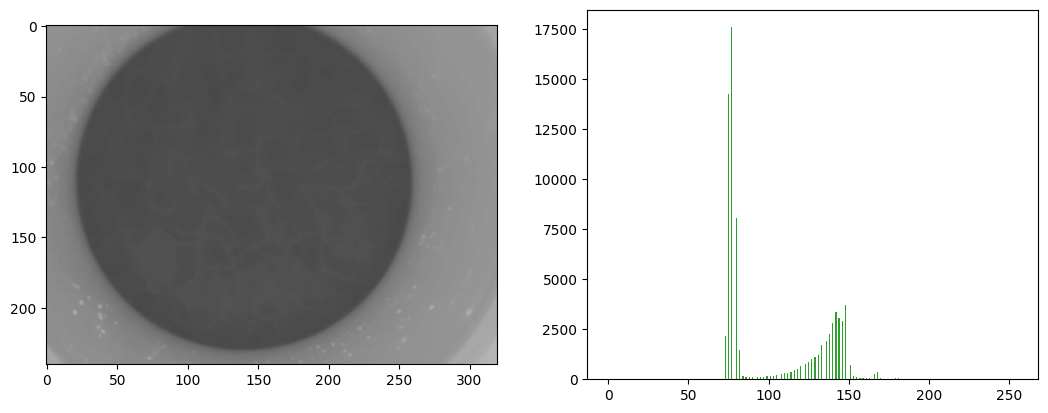

In [46]:
norm=normalizacion(img)
norm1=norm*255
plot_histogram(norm1)

# Ajuste de contraste no lineal

También es posible realizar ajuste con transformaciones no lineales. Una de las posibilidades es el ajuste de sigmoide, $s = \frac{1}{1 + e^{(\mathrm{cutoff} - r)\mathrm{gain}}}$ donde $s$ es el valor de píxel transformado, $r$ es la intensidad de entrada y $\mathrm{cutoff}$ y $\mathrm{gain}$ son parámetros. Esta ecuación asume que los valores de entrada están normalizados en el intervalo [0, 1].

> Realiza la representación de la función de transformación para $\mathrm{cutoff} = 0.5$ y $\mathrm{gain} = 12$.



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  752k  100  752k    0     0  2394k      0 --:--:-- --:--:-- --:--:-- 2425k


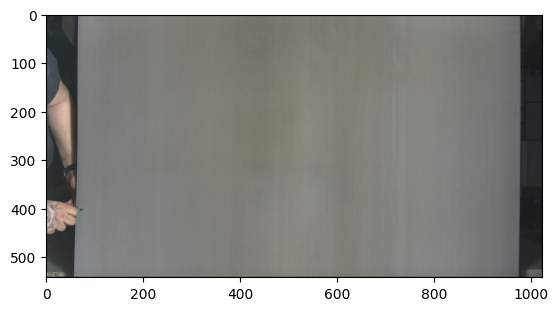

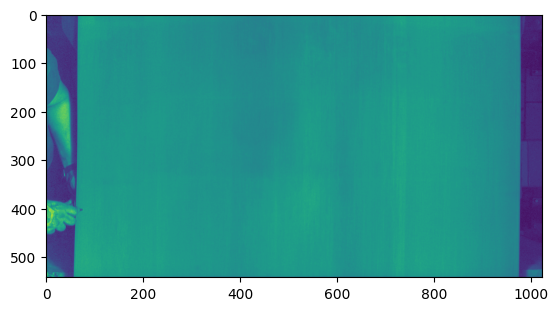

In [39]:
def sigmoide(img,cutoff,gain):
    s=np.clip(1 / (1 + np.exp((cutoff - img) * gain)), 0, 1)
    #transformed_image = 1 / (1 + np.exp((cutoff - image) * gain))
    return s




!curl www.atc.uniovi.es/grado/3va/prac/persona.png --output persona.jpg
img = skimage.io.imread('persona.jpg')
plt.imshow(img)
plt.show()
img2=normalizacion(img)
img3=sigmoide(img2,0.5,12)
plt.imshow(img2)

SE UTILIZA PARA AJUSAR EL CONTRASTE Y RESALTAR CIERTOS DETALLES EN ZONAS DE BAJA INTENSIDAD

Ahora realiza esta mejora de contraste en la imagen `http://www.atc.uniovi.es/grado/3va/prac/persona.png`.
